# Doing Data Science: chapter 2 - Housing Dataset

Python code for the exercise on the RealDirect study about the housing dataset ("*improve the way people sell and buy houses*").

**Author**: Damien Garaud

**Project on Github**: https://github.com/garaud/doing_pydata_science

## Getting Data 

Clone the official Github project at https://github.com/oreillymedia/doing_data_science and unzip the `dds_datasets.zip` file. You'll find a new ZIP file named `dds_chapter2_rollingsales.zip`. Then, you'll get five XLS files:

- `rollingsales_bronx.xls`
- `rollingsales_brooklyn.xls`
- `rollingsales_manhattan.xls`
- `rollingsales_queens.xls`
- `rollingsales_statenisland.xls`

**Note**: for each carried out task, I'll try to write a **function**. Functions are good.

## Modules

In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

# useful to explore data with null values
import missingno as msno

In [4]:
print(pd.__version__)

0.20.3


In [5]:
sns.set_context('talk')

**Note**: about the missingno package, visit https://github.com/ResidentMario/missingno You can install it with conda.

## Reading Data

You continue to use pandas for XLS files reading. Suppose you have the `rollingsales_AREA.xls` files in the `data` directory.

The relevant row number to extract header is the row no.5 (note: row spreadsheet begins to 1).

In [7]:
def read_data(fname):
    """Read data from an Excel file
    """
    return pd.read_excel(fname, header=4)

In [8]:
brooklyn = read_data("./data/rollingsales_brooklyn.xls")

In [9]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23373 entries, 0 to 23372
Data columns (total 21 columns):
BOROUGH                           23373 non-null int64
NEIGHBORHOOD                      23373 non-null object
BUILDING CLASS CATEGORY           23373 non-null object
TAX CLASS AT PRESENT              23373 non-null object
BLOCK                             23373 non-null int64
LOT                               23373 non-null int64
EASE-MENT                         23373 non-null object
BUILDING CLASS AT PRESENT         23373 non-null object
ADDRESS                           23373 non-null object
APART
MENT
NUMBER                 23373 non-null object
ZIP CODE                          23373 non-null int64
RESIDENTIAL UNITS                 23373 non-null int64
COMMERCIAL UNITS                  23373 non-null int64
TOTAL UNITS                       23373 non-null int64
LAND SQUARE FEET                  23373 non-null int64
GROSS SQUARE FEET                 23373 non-null int64
YEAR

21 columns and several different data

## Load and Clean up

Quoting: *First challenge: load in and clean up the data. Next, conduct
exploratory data analysis in order to find out where there are
outliers or missing values, decide how you will treat them, make
sure the dates are formatted correctly, make sure values you
think are numerical are being treated as such, etc.*

Rename some column names (there are some `\n`)

In [10]:
def clean_columns(df):
    """Clean some columns name
    """
    df.columns = [x.replace('\n', ' ').lower() for x in df.columns]
    return df.rename_axis({'apart ment number': 'apartment number',
                           'ease-ment': 'easement'}, axis=1)
    
def missing_string(df, colnames):
    """Strip content and fill empty string with NaN
    """
    df = df.copy()
    for col in colnames:
        df[col] = df[col].str.strip().apply(lambda x: None if not x else x)
    return df

Column `apart ment number` sounds strange and this is an object (i.e. a string). Rename it!

In [11]:
brooklyn = clean_columns(brooklyn)

In [12]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23373 entries, 0 to 23372
Data columns (total 21 columns):
borough                           23373 non-null int64
neighborhood                      23373 non-null object
building class category           23373 non-null object
tax class at present              23373 non-null object
block                             23373 non-null int64
lot                               23373 non-null int64
easement                          23373 non-null object
building class at present         23373 non-null object
address                           23373 non-null object
apartment number                  23373 non-null object
zip code                          23373 non-null int64
residential units                 23373 non-null int64
commercial units                  23373 non-null int64
total units                       23373 non-null int64
land square feet                  23373 non-null int64
gross square feet                 23373 non-null int64
year

OK, sometimes, you can have two digits or one digits and letters. We can normalize that, i.e. discard some trailing whitespaces. And replace every empty string by None.

In [13]:
brooklyn = missing_string(brooklyn, ['apartment number'])

Let's see if you have other string field with the same issues

In [14]:
brooklyn['apartment number'].sample(10)

16902     None
13101     None
6930      None
13242     None
20436      NaN
5554        3L
11066     None
11513     8 2F
11780    13 2E
14613     None
Name: apartment number, dtype: object

### Type of Columns

Are integer and string columns qualitative or sequential data?

* Districts or zipcodes could be qualitative data
* Years or prices could be sequential data (i.e. you can sort them)

In [15]:
def number_unique_values(data):
    """Count the number of unique values for each column
    
    Return a DataFrame with the name of the columns, the type and the number of unique values
    """
    res = pd.DataFrame([(name, data[name].dtype.name, data[name].nunique()) for name in data],
                      columns=['name', 'type', 'number'])
    return res.sort_values(by=['type', 'number'])

In [16]:
nuniq = number_unique_values(brooklyn)

In [17]:
nuniq

,name,type,number
20,sale date,datetime64[ns],373
0,borough,int64,1
17,tax class at time of sale,int64,4
12,commercial units,int64,27
10,zip code,int64,41
11,residential units,int64,91
13,total units,int64,96
16,year built,int64,145
5,lot,int64,1134
14,land square feet,int64,2552


**Note** that *most of the time*, `object` type means `string`.

When you have a small number of unique values in comparison with the number of rows, it could be qualitative data.

For a predictive model, the columns with a unique value are irrelevant.
I'm specifying two list of columns:
- columns with string data
- columns with integer data

In [18]:
intcols = nuniq.query("type == 'int64'")['name'].values.tolist()
strcols = nuniq.query("type == 'object'")['name'].values.tolist()

### Crazy Values

Data are always messed up. Check if some integer/float columns contain some crazy values, e.g. -999 for a positive float or 0 for years...

In [19]:
def range_columns(data):
    """Min/max values for each integer columns
    """
    intcols = data.dtypes[data.dtypes == 'int64'].index.tolist()
    res = data[intcols].describe().T
    return res[["min", "50%", "max"]]

In [20]:
range_columns(brooklyn)

,min,50%,max
borough,3.0,3.0,3.0
block,20.0,3839.0,8955.0
lot,1.0,48.0,9039.0
zip code,0.0,11218.0,11416.0
residential units,0.0,1.0,509.0
commercial units,0.0,0.0,222.0
total units,0.0,1.0,509.0
land square feet,0.0,1850.0,7446955.0
gross square feet,0.0,1760.0,2548000.0
year built,0.0,1925.0,2013.0


zip code, sale price, square feet or year equal to `0` is quite strange! Next step: **identify** null values. For some integer values, you can suppose that 0 is a null value. For string values, you can suppose that the empty string is null. You have a dedicated function for the second issue.

In [21]:
brooklyn = missing_string(brooklyn, strcols)

Let's select the integer columns where you can say: "zero value is a null value".

In [22]:
intcols

['borough',
 'tax class at time of sale',
 'commercial units',
 'zip code',
 'residential units',
 'total units',
 'year built',
 'lot',
 'land square feet',
 'gross square feet',
 'sale price',
 'block']

In [23]:
intcols_to_nullify = ['zip code', 'year built', 'land square feet',
                      'gross square feet', 'sale price']

In [24]:
brooklyn[intcols_to_nullify].head()

,zip code,year built,land square feet,gross square feet,sale price
0,11220,0,0,0,403572
1,11220,0,0,0,218010
2,11238,0,0,0,952311
3,11238,0,0,0,842692
4,11238,0,0,0,815288


In [25]:
brooklyn[intcols_to_nullify] = brooklyn[intcols_to_nullify].replace(0, np.nan)

Now, you have a number of non-null object values which is quite different of the total number of rows.

Now, you have a better representation of your data. As you can see, you have multiple rows where there are some null values.

In [26]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23373 entries, 0 to 23372
Data columns (total 21 columns):
borough                           23373 non-null int64
neighborhood                      23365 non-null object
building class category           23043 non-null object
tax class at present              3779 non-null object
block                             23373 non-null int64
lot                               23373 non-null int64
easement                          0 non-null object
building class at present         23272 non-null object
address                           23373 non-null object
apartment number                  4112 non-null object
zip code                          23356 non-null float64
residential units                 23373 non-null int64
commercial units                  23373 non-null int64
total units                       23373 non-null int64
land square feet                  15346 non-null float64
gross square feet                 14439 non-null float64
year

You can use the `missingno` package which works well with pandas and seaborn to visualize features (i.e. columns) with missing values.

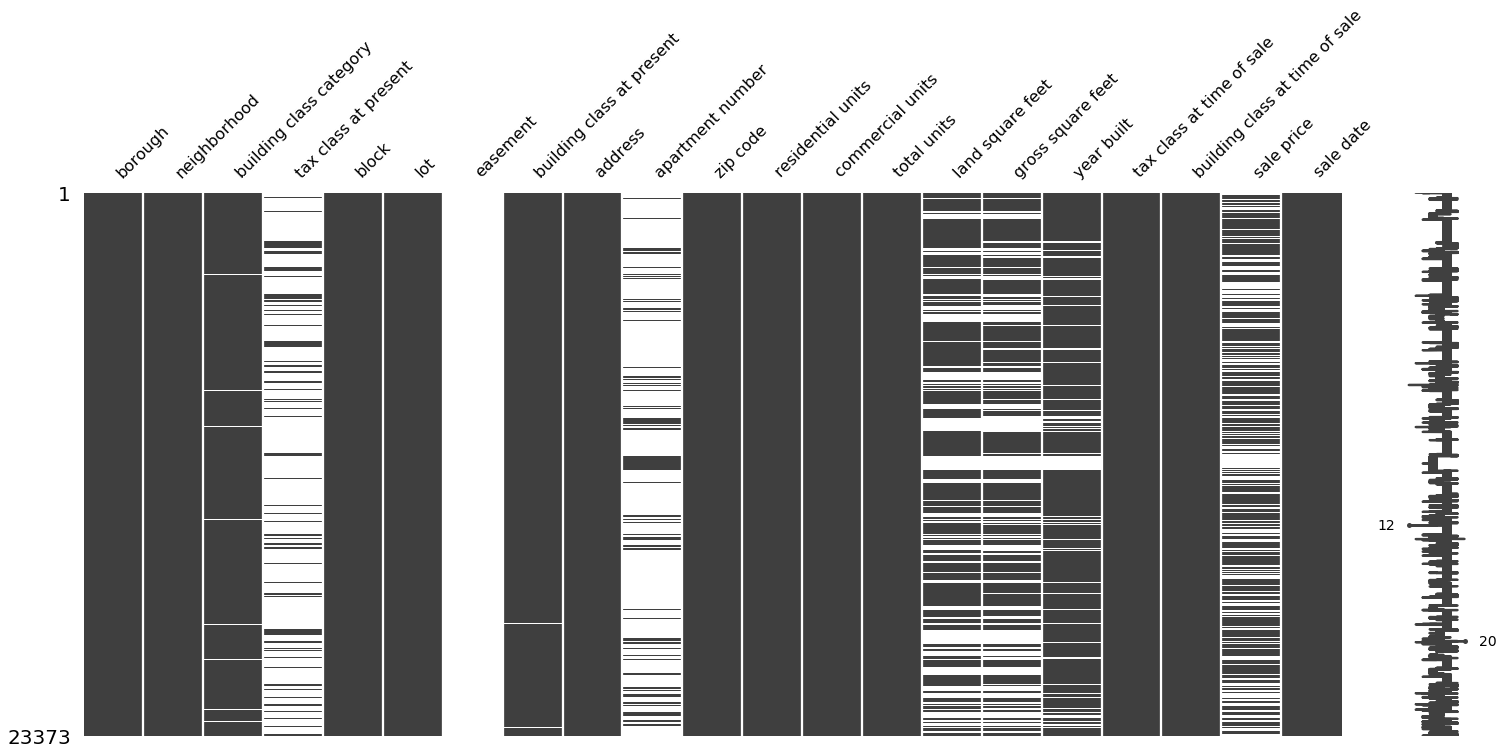

In [27]:
msno.matrix(brooklyn)

You can also plot the correlation of "number of missing values" between each feature.

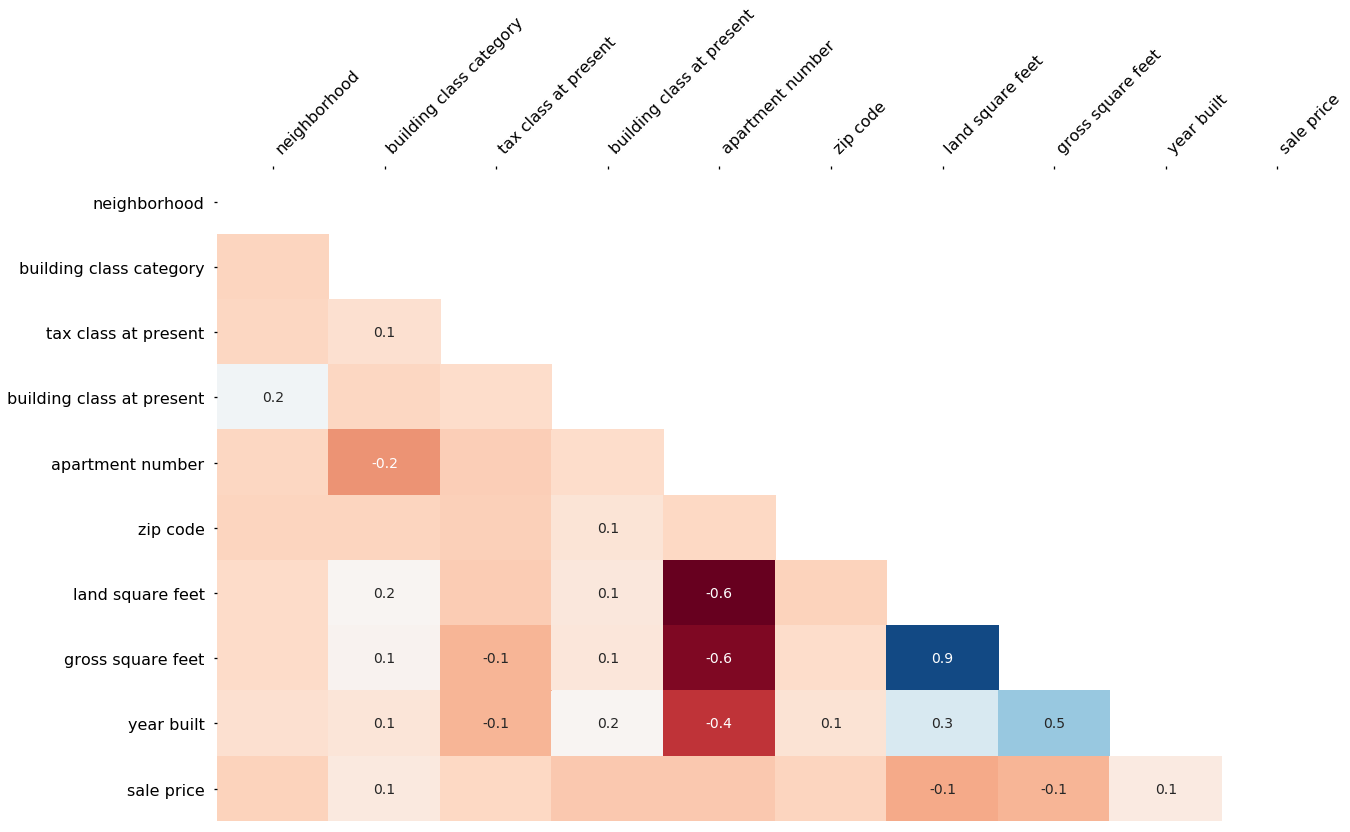

In [28]:
msno.heatmap(brooklyn)

As you can see, there is a huge correlation between the 'land square feet' and 'gross square feet' feature. It's not very suprising since when you don't have the value of the first feature, you don't have the second one.

For a predictive model which tries to estimate the sale price for instance, you need to remove some lines (where you have these null values) and some features (unique values, etc.). In this study, you can drop `easement` and `borough` columns.

In [29]:
intcols.remove('borough')
brooklyn = brooklyn.drop(['easement', 'borough'], axis=1)

### Correlation

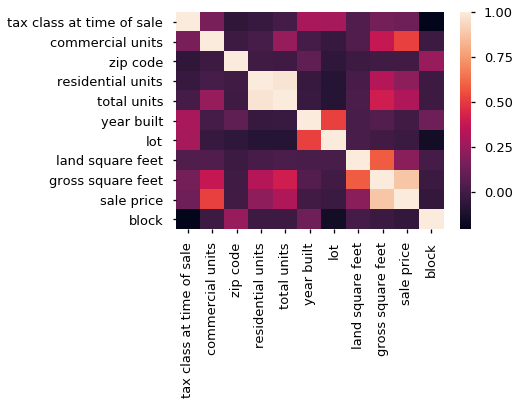

In [30]:
sns.heatmap(brooklyn[intcols].corr())